<a href="https://colab.research.google.com/github/fahimehfarah/Tutorial-Fusion2023/blob/main/Peat_Core_Water_Fahimeh_with_feedback_2_7_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# ==================================================
# Install required libraries
# ==================================================
!pip install -q openai langchain langchain-community


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [ ]:

# ==================================================
# Imports
# ==================================================
import openai
import pandas as pd
import numpy as np
import re
import json
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, AIMessage
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings
warnings.filterwarnings('ignore')


In [ ]:

# ==================================================
# API setup
# ==================================================
key = "your_key_here"
openai.api_key = key
llm = ChatOpenAI(openai_api_key=key, model_name="gpt-4o-mini")

In [ ]:
# ==================================================
# Load and clean dataset
# ==================================================
data = pd.read_csv("./DPH_Peat_Core_Water_Content_and_Temperature_20230112.csv")
# Convert to numeric if necessary
cols = ['Temp_treatment', 'Top_core_depth', 'Bottom_core_depth',
        'Mid_core_depth', 'Moisture_fraction', 'Dried_archive', 'Sample_Temperature']

# ==================================================
# Nan values
# ==================================================
df = data.iloc[1:]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df['Dried_archive'] = df['Moisture_fraction'].astype(float)
df['Sample_Temperature'] = df['Sample_Temperature'].astype(float)
df['Moisture_fraction'] = df['Moisture_fraction'].astype(float)

df.fillna({
    'Dried_archive': df['Dried_archive'].mean(),
    'Sample_Temperature': df['Sample_Temperature'].mean(),
    'Moisture_fraction': df['Moisture_fraction'].mean()
}, inplace=True)


In [ ]:
df.columns

Index(['Plot', 'Temp_treatment', 'Sampling_date', 'Top_core_depth',
       'Bottom_core_depth', 'Mid_core_depth', 'Moisture_fraction',
       'Dried_archive', 'Sample_Temperature', 'Notes'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 1 to 330
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Plot                330 non-null    float64
 1   Temp_treatment      330 non-null    float64
 2   Sampling_date       330 non-null    object 
 3   Top_core_depth      330 non-null    int64  
 4   Bottom_core_depth   330 non-null    int64  
 5   Mid_core_depth      330 non-null    float64
 6   Moisture_fraction   330 non-null    float64
 7   Dried_archive       330 non-null    float64
 8   Sample_Temperature  330 non-null    float64
 9   Notes               54 non-null     object 
dtypes: float64(6), int64(2), object(2)
memory usage: 25.9+ KB


In [ ]:
df.head()

,Plot,Temp_treatment,Sampling_date,Top_core_depth,Bottom_core_depth,Mid_core_depth,Moisture_fraction,Dried_archive,Sample_Temperature,Notes
1,4.0,4.5,2014-06-03,0,-10,-5.0,14.06,14.06,11.19239,NaN
2,4.0,4.5,2014-06-03,-10,-20,-15.0,21.89,21.89,11.19239,NaN
3,4.0,4.5,2014-06-03,-20,-30,-25.0,11.88,11.88,11.19239,NaN
4,4.0,4.5,2014-06-03,-30,-40,-35.0,11.89,11.89,11.19239,NaN
5,4.0,4.5,2014-06-03,-40,-50,-45.0,6.88,6.88,11.19239,NaN


In [ ]:
df.columns

Index(['Plot', 'Temp_treatment', 'Sampling_date', 'Top_core_depth',
       'Bottom_core_depth', 'Mid_core_depth', 'Moisture_fraction',
       'Dried_archive', 'Sample_Temperature', 'Notes'],
      dtype='object')

In [ ]:
set(df['Plot'])

{4.0, 6.0, 8.0, 10.0, 11.0, 13.0, 16.0, 17.0, 19.0, 20.0}

In [ ]:
import matplotlib.pyplot as plt


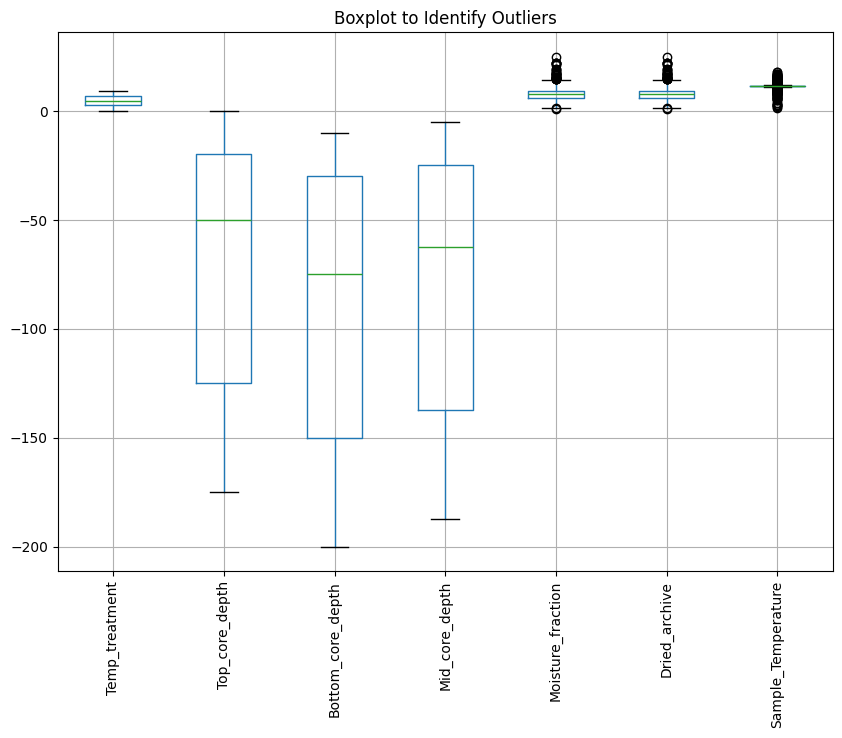

In [ ]:
# ==================================================
# Outliers
# ==================================================
plt.figure(figsize=(10, 7))
df[cols].boxplot()
plt.xticks(rotation=90)
plt.title("Boxplot to Identify Outliers")
plt.show()

In [ ]:
# ==================================================
# Outliers
# ==================================================
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

df_cleaned = df.copy()
for col in ['Temp_treatment', 'Top_core_depth', 'Bottom_core_depth', 'Mid_core_depth', 'Moisture_fraction', 'Dried_archive', 'Sample_Temperature']:
    df_cleaned = remove_outliers_iqr(df_cleaned, col)


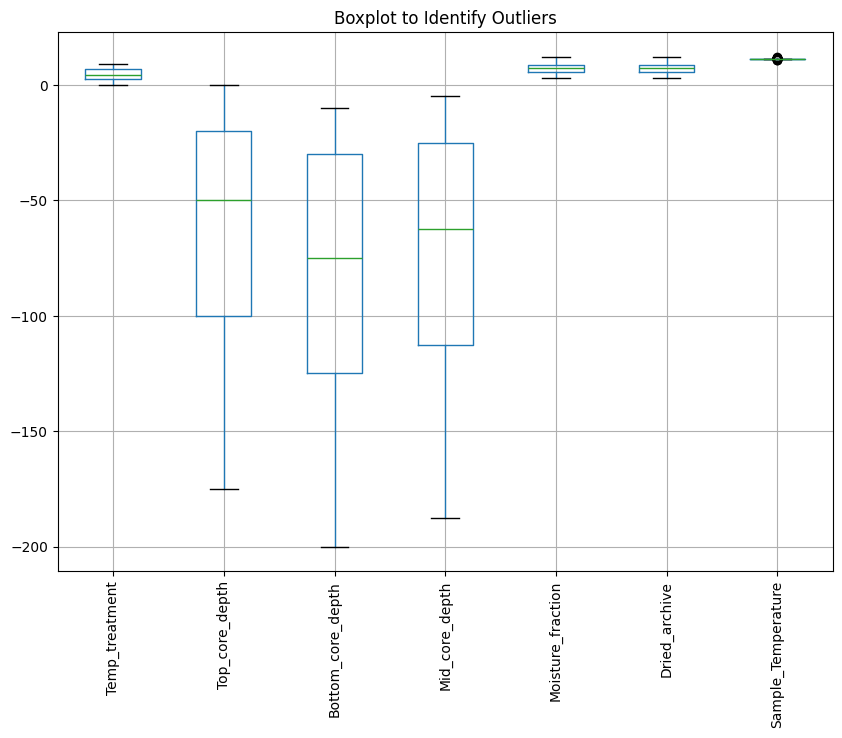

In [ ]:
# ==================================================
# Outliers
# ==================================================
plt.figure(figsize=(10, 7))
df_cleaned[cols].boxplot()
plt.xticks(rotation=90)
plt.title("Boxplot to Identify Outliers")
plt.show()

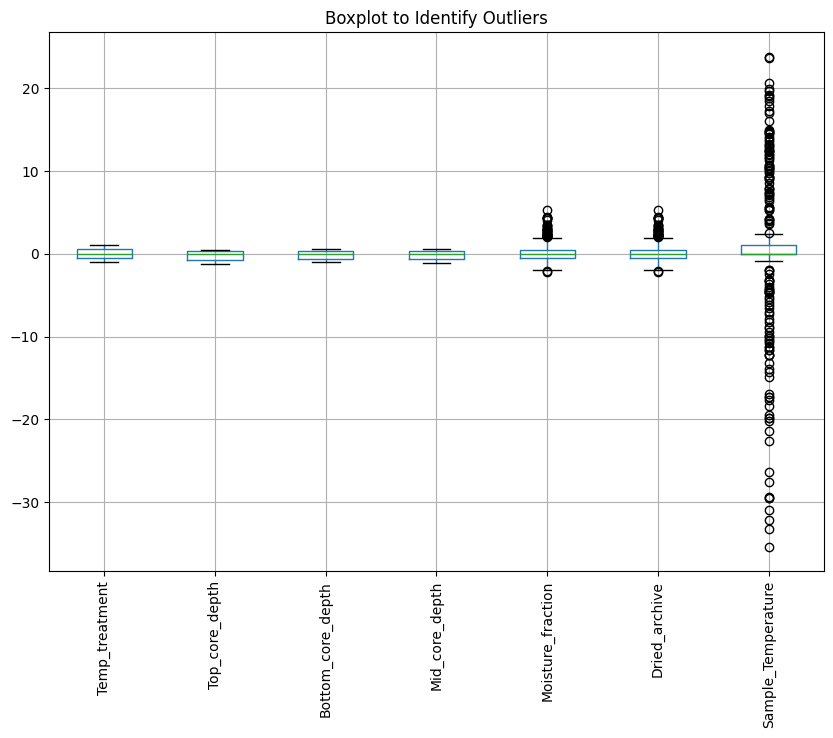

In [ ]:
# ==================================================
# Outliers
# ==================================================
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[cols]), columns=cols)
plt.figure(figsize=(10, 7))
df_scaled[cols].boxplot()
plt.xticks(rotation=90)
plt.title("Boxplot to Identify Outliers")
plt.show()

In [ ]:
# ==================================================
# Run after removing outliers
# ==================================================
def extract_number(value):
    if pd.isnull(value):
        return np.nan
    match = re.search(r"-?\d+\.?\d*", str(value))
    return float(match.group()) if match else np.nan

columns_to_convert = [
    "Top_core_depth", "Bottom_core_depth", "Mid_core_depth",
    "Moisture_fraction", "Dried_archive", "Sample_Temperature"
]
for col in columns_to_convert:
    df_cleaned[col] = df_cleaned[col].apply(extract_number)

df_cleaned.dropna(subset=["Mid_core_depth"], inplace=True)

# ==================================================
# Feature engineering and training
# ==================================================
exclude_columns = ["Mid_core_depth", "Notes", "Sampling_date"]
feature_cols = [col for col in df_cleaned.columns if col not in exclude_columns]
X = df_cleaned[feature_cols].dropna()
y = df_cleaned["Mid_core_depth"].loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=8)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

joblib.dump(model, "peatland_model_rf.pkl")

# ==================================================
# What-If Scenario Example
# ==================================================
new_sample = {
    "Plot": [12],
    "Temp_treatment": [18],
    "Top_core_depth": [-10],
    "Bottom_core_depth": [-20],
    "Moisture_fraction": [15.5],
    "Dried_archive": [1.2],
    "Sample_Temperature": [13.8]
}
new_df = pd.DataFrame(new_sample)

# Predict
new_prediction = model.predict(new_df)
print(f"\nWhat-If Scenario -> Predicted Mid_core_depth: {new_prediction[0]:.2f}")
prediction = new_prediction[0]

# ==================================================
# Prompt Template
# ==================================================
prompt = f"""You are an expert in peatland hydrology and environmental monitoring.
I will give you input conditions and a predicted result.
Your job is to explain this result clearly, in simple language, for a non-technical person.

Input:
- Plot Number: 12
- Temperature Treatment: 18 °C
- Top core depth: -10 cm
- Bottom core depth: -20 cm
- Moisture Fraction: 15.5 g water/g dry peat
- Dried Archive: 1.2 g
- Sample Temperature: 13.8 °C

Output:
Predicted Mid-core Depth: {prediction:.2f} cm

Please now write a plain-language summary for a general user.
"""

# ==================================================
# Word-wrapping function
# ==================================================
def insert_newlines(text, words_per_line=15):
    words = text.split()
    return '\n'.join(' '.join(words[i:i+words_per_line]) for i in range(0, len(words), words_per_line))

R2 Score: 1.000
RMSE: 0.054

What-If Scenario -> Predicted Mid_core_depth: -14.90


In [ ]:
# ==================================================
# Run without removing outliers
# ==================================================
for col in columns_to_convert:
    df[col] = df[col].apply(extract_number)

df.dropna(subset=["Mid_core_depth"], inplace=True)

# ==================================================
# Feature engineering and training
# ==================================================
exclude_columns = ["Mid_core_depth", "Notes", "Sampling_date"]
feature_cols = [col for col in df.columns if col not in exclude_columns]
X = df[feature_cols].dropna()
y = df["Mid_core_depth"].loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=8)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

joblib.dump(model, "peatland_model_rf.pkl")

# ==================================================
# What-If Scenario Example
# ==================================================
new_sample = {
    "Plot": [12],
    "Temp_treatment": [18],
    "Top_core_depth": [-10],
    "Bottom_core_depth": [-20],
    "Moisture_fraction": [15.5],
    "Dried_archive": [1.2],
    "Sample_Temperature": [13.8]
}
new_df = pd.DataFrame(new_sample)

# Predict
new_prediction = model.predict(new_df)
print(f"\nWhat-If Scenario -> Predicted Mid_core_depth: {new_prediction[0]:.2f}")
prediction = new_prediction[0]

# ==================================================
# Prompt Template
# ==================================================
prompt = f"""You are an expert in peatland hydrology and environmental monitoring.
I will give you input conditions and a predicted result.
Your job is to explain this result clearly, in simple language, for a non-technical person.

Input:
- Plot Number: 12
- Temperature Treatment: 18 °C
- Top core depth: -10 cm
- Bottom core depth: -20 cm
- Moisture Fraction: 15.5 g water/g dry peat
- Dried Archive: 1.2 g
- Sample Temperature: 13.8 °C

Output:
Predicted Mid-core Depth: {prediction:.2f} cm

Please now write a plain-language summary for a general user.
"""

# ==================================================
# Word-wrapping function
# ==================================================
def insert_newlines(text, words_per_line=15):
    words = text.split()
    return '\n'.join(' '.join(words[i:i+words_per_line]) for i in range(0, len(words), words_per_line))

R2 Score: 1.000
RMSE: 0.000

What-If Scenario -> Predicted Mid_core_depth: -15.00


In [ ]:
# ==================================================
# Run LLM
# ==================================================
response = llm([HumanMessage(content=prompt)])
generated_text = response.content
print(insert_newlines(generated_text))


In our study of peatland, we've been looking closely at the moisture conditions at different
depths in the soil. For a specific area we call Plot Number 12, we conducted
an experiment at a temperature of 18 °C. We took samples from two different depths
in the soil: one from 10 centimeters below the surface and another from 20 centimeters
below. We found that the moisture content in the peat, which is a type of
soil rich in organic material, was 15.5 grams of water for every gram of dry
peat. This means the peat is holding a good amount of water, which is important
for the health of the peatland ecosystem. When we looked at the conditions more closely,
we predicted that if we were to take a sample from the middle of the
two depths we measured (between -10 cm and -20 cm), it would be at a
depth of -15.00 cm. This mid-point helps us understand the average conditions in that area
of the peatland, which is crucial for monitoring how these ecosystems respond to changes in
temperature and moi

In [ ]:
#old result
generated_text = "In Plot Number 12, we are looking at how moisture levels and temperature affect the peatland environment. The temperature treatment for this plot is set at 18 °C, which is a moderate warmth that can influence how much water the peat holds. We took samples from two different depths: the top core is at 10 cm below the surface, and the bottom core is at 20 cm below the surface. The moisture fraction, which tells us how much water is in the peat compared to the dry material, is 15.5 grams of water for every gram of dry peat. This indicates that the peat is relatively wet, which is typical for peatlands. Now, the predicted mid-core depth is at -15.00 cm, meaning that if we were to take a sample right in the middle of our two core depths (10 cm and 20 cm), it would be at 15 cm below the surface. This depth is considered quite deep for peat, suggesting that there is a significant amount of peat material above it. The environmental implication of this is important. With the moisture fraction being relatively high, it indicates that the site is sufficiently wet, which is good for peatland health. However, if the area were to dry out too much, it could negatively affect the plants and wildlife that rely on this wet environment. Peatlands are crucial for storing carbon and supporting biodiversity, so maintaining the right moisture levels is key to their health and the overall ecosystem."

In [ ]:
# ==================================================
# Feedback Collection (manual entry)
# ==================================================
user_feedback = input("Please provide feedback on the LLM output: ")

Please provide feedback on the LLM output: "The explanation is written in a clear and simple way, which is appreciated. "     "However, there are several scientific inaccuracies and missing context. "     "For instance, the model misinterprets the temperature treatment (18°C) as an absolute value, "     "while in the dataset it's actually a temperature increase (0–9°C). "     "The explanation also assumes two separate samples at different depths, when the sampling actually "     "covers the range between those depths. The term 'mid-core depth' is misused, and calling 15 cm 'quite deep' "     "is incorrect—it's actually shallow for peat. Moreover, while general environmental implications are mentioned, "     "they're overly broad. It would be more helpful to compare the moisture fraction to known benchmarks "     "(e.g., pristine vs. drained peatlands). Overall, the output needs better grounding in the dataset's context and peatland science."


In [ ]:
user_feedback

'"The explanation is written in a clear and simple way, which is appreciated. "     "However, there are several scientific inaccuracies and missing context. "     "For instance, the model misinterprets the temperature treatment (18°C) as an absolute value, "     "while in the dataset it\'s actually a temperature increase (0–9°C). "     "The explanation also assumes two separate samples at different depths, when the sampling actually "     "covers the range between those depths. The term \'mid-core depth\' is misused, and calling 15 cm \'quite deep\' "     "is incorrect—it\'s actually shallow for peat. Moreover, while general environmental implications are mentioned, "     "they\'re overly broad. It would be more helpful to compare the moisture fraction to known benchmarks "     "(e.g., pristine vs. drained peatlands). Overall, the output needs better grounding in the dataset\'s context and peatland science."'

In [ ]:
# Save feedback to JSONL file
feedback_log = {
    "prompt": prompt,
    "response": generated_text,
    "feedback": user_feedback
}
with open("llm_feedback_log.jsonl", "a") as f:
    f.write(json.dumps(feedback_log) + "\n")

In [ ]:
# ==================================================
#Regenerate using feedback with providing previous generated text by the LLM
# ==================================================
messages = [
    HumanMessage(content=prompt),
    AIMessage(content=generated_text),
    HumanMessage(content=f"The explanation above received the following feedback:\n{user_feedback}\nPlease improve it and rewrite the explanation more clearly. Keep it simple and avoid technical jargon."),
]

regenerated_response = llm(messages)

regenerated_response.content

AIMessage(content="In Plot Number 12, we're studying how temperature and moisture levels affect the health of peatland, a type of wetland that stores a lot of carbon. The temperature treatment here is an increase to 18 °C, which means we are looking at how the peat responds to being warmed by this amount.\n\nWe collected a sample from the peat that stretches between 10 cm and 20 cm below the surface. The moisture fraction measured is 15.5 grams of water for every gram of dry peat. This tells us that the peat is quite wet, which is important for its health. In fact, this level of moisture is generally higher than what you would find in drained peatlands, where the water is much less and the ecosystem is stressed.\n\nThe predicted mid-core depth is at -15.00 cm, which is simply the halfway point between our two sampling depths. While this depth might seem significant, it is actually considered shallow for peatlands, which can have much deeper layers of peat.\n\nOverall, maintaining a hig

In [ ]:
# Result with showing the previous answer
print(insert_newlines(regenerated_response.content))

In Plot Number 12, we're studying how temperature and moisture levels affect the health of
peatland, a type of wetland that stores a lot of carbon. The temperature treatment here
is an increase to 18 °C, which means we are looking at how the peat
responds to being warmed by this amount. We collected a sample from the peat that
stretches between 10 cm and 20 cm below the surface. The moisture fraction measured is
15.5 grams of water for every gram of dry peat. This tells us that the
peat is quite wet, which is important for its health. In fact, this level of
moisture is generally higher than what you would find in drained peatlands, where the water
is much less and the ecosystem is stressed. The predicted mid-core depth is at -15.00
cm, which is simply the halfway point between our two sampling depths. While this depth
might seem significant, it is actually considered shallow for peatlands, which can have much deeper
layers of peat. Overall, maintaining a high moisture level is crucial 

In [ ]:
# ==================================================
#Regenerate using feedback without showing the previous answer
# ==================================================
regeneration_prompt = f"""The previous explanation was reviewed and got this feedback:
"{user_feedback}"

Please rewrite the explanation more clearly. Keep it simple and avoid technical jargon.

Original input:
{prompt}
"""

regenerated_response = llm([HumanMessage(content=regeneration_prompt)])
print("\nRegenerated Explanation:\n")
print(insert_newlines(regenerated_response.content))



Regenerated Explanation:

Sure! Here’s a simplified summary based on the provided input: --- **Summary of Peatland Monitoring
Results** In our study of Plot Number 12, we looked at how temperature affects the
moisture in peat soil. The temperature we used for the experiment was a rise to
18°C, which is warmer than the usual conditions. We took samples from a layer of
peat that is about 10 to 20 centimeters deep, with our main focus being around
15 centimeters deep. This depth is relatively shallow for peatlands, which can have much deeper
layers. The moisture content we found in the peat was 15.5 grams of water for
every gram of dry peat. This tells us how much water is held in the
peat, which is important for understanding its health and function. Additionally, we measured the temperature
of the peat sample itself, which was 13.8°C during our study. Overall, the results help
us understand how temperature changes can affect peatland moisture, which is crucial for maintaining these
eco

In [ ]:
# Result without showing the previous answer

def extract_between_dashes(text):
    """Extracts the first block of text between --- markers and removing * """
    matches = re.findall(r"---\s*(.*?)\s*---", text, flags=re.DOTALL)
    if matches:
      text = matches[0].strip()
      text = text.replace("*", "")
      return text
    else:
        return "No content found between --- markers."
print("\nRegenerated Explanation:\n")
raw_response = regenerated_response.content  # my note: response.choices[0].message.content if using openai directly
clean_text = extract_between_dashes(raw_response)
insert_newlines(clean_text)
print(insert_newlines(clean_text))


Regenerated Explanation:

Summary of Peatland Monitoring Results In our study of Plot Number 12, we looked at
how temperature affects the moisture in peat soil. The temperature we used for the experiment
was a rise to 18°C, which is warmer than the usual conditions. We took samples
from a layer of peat that is about 10 to 20 centimeters deep, with our
main focus being around 15 centimeters deep. This depth is relatively shallow for peatlands, which
can have much deeper layers. The moisture content we found in the peat was 15.5
grams of water for every gram of dry peat. This tells us how much water
is held in the peat, which is important for understanding its health and function. Additionally,
we measured the temperature of the peat sample itself, which was 13.8°C during our study.
Overall, the results help us understand how temperature changes can affect peatland moisture, which is
crucial for maintaining these ecosystems.
